# Notebook 3: Analyzing phenotypic nonlinearity of predicted phenotypes

---

><font size="3"> This is the third of three notebooks associated with the [pub](https://research.arcadiascience.com/pub/result-nonlinear-phenotypes/) "Harnessing genotype-phenotype nonlinearity to accelerate biological prediction".
>
><font size="3"> In this notebook (**Notebook 3**), we will assess the results of an autoencoder model that was created to do phenotype-phenotype prediction. As a class of neural network, autoencoders can learn both linear and nonlinear relationships and use them to make predictions. The specific model presented in the pub was trained on the same type of synthetic data that was analyzed in **Notebook 2** (i.e. phenotypes generated from a range of pleiotropy/gene-gene interaction probabilities). 
>   
><font size="3"> Here, we will explore how varying the number of input phenotypes effects autoencoder performance, the role of pleiotropy in model performance, and the relationship between nonlinearity/entropy and predictive ability. 
>   
><font size="3">All the data necessary for running this notebook are available via [Zenodo](https://zenodo.org/record/8298808). Please follow the code in **Notebook 1** to download before preceeding.

---

## Initiating workspace and loading data

<font size="3"> Set working directory.

In [24]:
library(here)
here::here() # Should be set to the root of the repository
setwd(here::here())

[1] "/Users/ryanyork/Documents/Research/github/accounting-for-nonlinear-phenotypes"

<font size="3"> Source functions.

In [25]:
suppressPackageStartupMessages(source('01_code/R/nonlinear_phenotype_utils.R'))

<font size="3"> The autoencoder model was trained on a set of synthetic phenotypes that were generated from genotypes with a range of pleiotropy/gene-gene interaction probabilities (as in **Notebook 2**). Here, we will load these phenotypes in order to later calculate their patterns of nonlinearity and entropy.

In [26]:
# Unzip
system('unzip data/autoencoder_phenotypes.zip -d data/')

# Generate empty list to populate with data
phens <- list()

# List files in directory
files <- list.files("data/autoencoder_phenotypes/")

# Extract just data used as input (labeled 'train')
files <- files[grep("train", files)]

# Loop through and load
for (i in 1:length(files)) {
    
  # Load pickled file
  tmp <- pd$read_pickle(paste("data/autoencoder_phenotypes/", files[i], sep = ""))
    
  # Convert list into matrix and add to list
  phens[[files[i]]] <- do.call(rbind, tmp)
}

><font size="3"> Next, we will load data describing the accuracy of phenotypic predictions made from different iterations of the autoencoder model (for details see the [pub](https://research.arcadiascience.com/pub/result-nonlinear-phenotypes/)). 
>   
><font size="3"> Briefly, four classes of models were used to perform phenotypic predictions: **1)** 5 input phenotypes, **2)** 10 input phenotypes, **3)** 20 input phenotypes, and **4)** 30 input phenotypes. The task in each case was to predict 5 phenotypes. Accuracy was measured by calculating the percent error between observed and predicted phenotypes.
>    
><font size="3"> Each class of model was run on synthetic phenotypes gerneated from all possible combinations of pleiotropy and gene-gene interaction probability (10,201 datasets, as in **Notebook 2**).

---

<font size="3"> Load autoencoder results.

In [27]:
dat <- read.csv('data/all_autoencoder_phenotype_predictions.csv')

<font size="3"> Generate a matrix with the corresponding % error values for all autoencoder runs.

In [28]:
# Split the data matrix on unique combinations of model class, pleiotropy probability, and gene-gene interaction probability
all_error <- split(dat, as.character(paste(dat$n_phens_predicted,
  dat$n_phens_analyzed,
  dat$p_pleio,
  dat$p_int,
  sep = "_"
)))

# Loop through list and clean/simplify
for (i in 1:length(all_error)) {
  # Remove brackets from error values
  x <- gsub("\\[", "", all_error[[i]]$mean_percent_error_values)
  x <- gsub("\\]", "", x)
  # Split elements on comma
  x <- unlist(strsplit(x, ", "))
  # Simplify elements
  x <- data.frame(
    p_pleio = rep(all_error[[i]]$p_pleio, length(x)),
    p_int = rep(all_error[[i]]$p_int, length(x)),
    n_phens_predicted = rep(all_error[[i]]$n_phens_predicted, length(x)),
    n_phens_analyzed = rep(all_error[[i]]$n_phens_analyzed, length(x)),
    mean_percent_error_values = as.numeric(x)
  )
  # Add to list
  all_error[[i]] <- x
}
# Combine list into matrix
all_error <- do.call(rbind, all_error)

<font size="3"> Reorder and match phenotypes and error as a function of pleiotropy and gene interaction probabilities.

In [29]:
# Split input phenotypes on model class (n of input phenotypes)
dat_nphenos <- split(
  dat,
  as.character(paste(dat$n_phens_predicted,
    dat$n_phens_analyzed,
    sep = "_"
  ))
)
# Split autoencoder results on model class (n of input phenotypes)
all_error_nphenos <- split(
  all_error,
  as.character(paste(all_error$n_phens_predicted,
    all_error$n_phens_analyzed,
    sep = "_"
  ))
)

# Reorder both so that the order matches n of input phenotypes (i.e. 5, 10, 20, 30)
dat_nphenos <- c(dat_nphenos[4], dat_nphenos[1:3])
all_error_nphenos <- c(all_error_nphenos[4], all_error_nphenos[1:3])

# Split on p_pleio and p_int
dat_pleio <- split(
  all_error,
  as.character(all_error$p_pleio)
)
dat_int <- split(
  all_error,
  as.character(all_error$p_int)
)

## Analyzing error distributions

><font size="3"> In this section we will analyze autoencoder model accuracy as a function of model class (i.e. # of input phenotypes) and pleiotropy. 

<font size="3"> Compare error as a function of input phenotype number via violin plots.

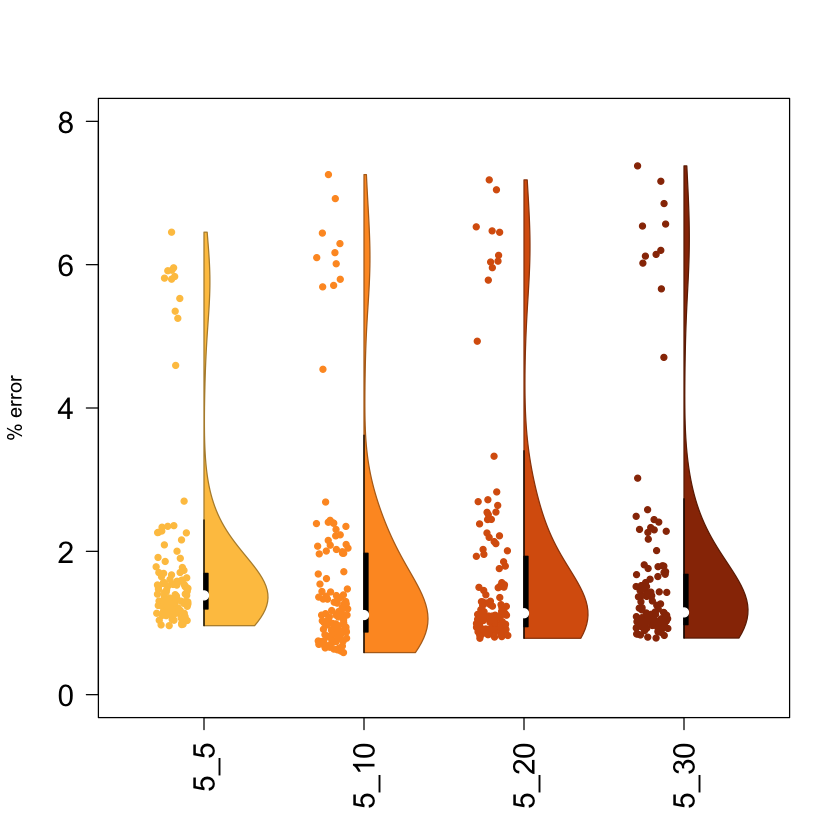

In [30]:
# Get colors
cols <- RColorBrewer::brewer.pal(6, "YlOrBr")[3:6]

# Half violin plots
vioplot::vioplot(lapply(dat_nphenos, function(x) x$average_mean_percent_error),
  col = cols,
  side = "right",
  border = darken_color(cols),
  ylab = "% error",
  xlab = "",
  font.main = 1,
  cex.main = 1.5,
  las = 2,
  ylim = c(0, 8),
  names = names(dat_nphenos),
  cex.axis = 1.5,
  cex.lab = 1.5
)

stripchart(lapply(dat_nphenos, function(x) x$average_mean_percent_error),
  col = cols,
  at = seq(0.8, (length(dat_nphenos) - 1) + 0.8, 1),
  jitter = 0.1,
  method = "jitter",
  vertical = TRUE,
  cex = 1,
  pch = 20,
  add = TRUE
)

<font size="3"> Calculate error mean and variance as a function of pleiotropy.

In [31]:
# Generate empty list to save variance into
v <- list()
# Generate empty list to save means into
means <- list()
# Generate emptry list to save standard error into
error <- list()
# Loop and calculate
for (i in 1:length(all_error_nphenos)) {
  # Calculate variance
  v[[i]] <- unlist(lapply(split(
    all_error_nphenos[[i]],
    all_error_nphenos[[i]]$p_pleio
  ), function(x) {
    var(x$mean_percent_error_values) / mean(x$mean_percent_error_values)
  }))
  # Calculate means
  means[[i]] <- unlist(lapply(split(
    all_error_nphenos[[i]],
    all_error_nphenos[[i]]$p_pleio
  ), function(x) {
    mean(x$mean_percent_error_values)
  }))
  # Calculate standard error
  error[[i]] <- unlist(lapply(split(
    all_error_nphenos[[i]],
    all_error_nphenos[[i]]$p_pleio
  ), function(x) {
    plotrix::std.error(x$mean_percent_error_values)
  }))
}

<font size="3"> Plot distribution.

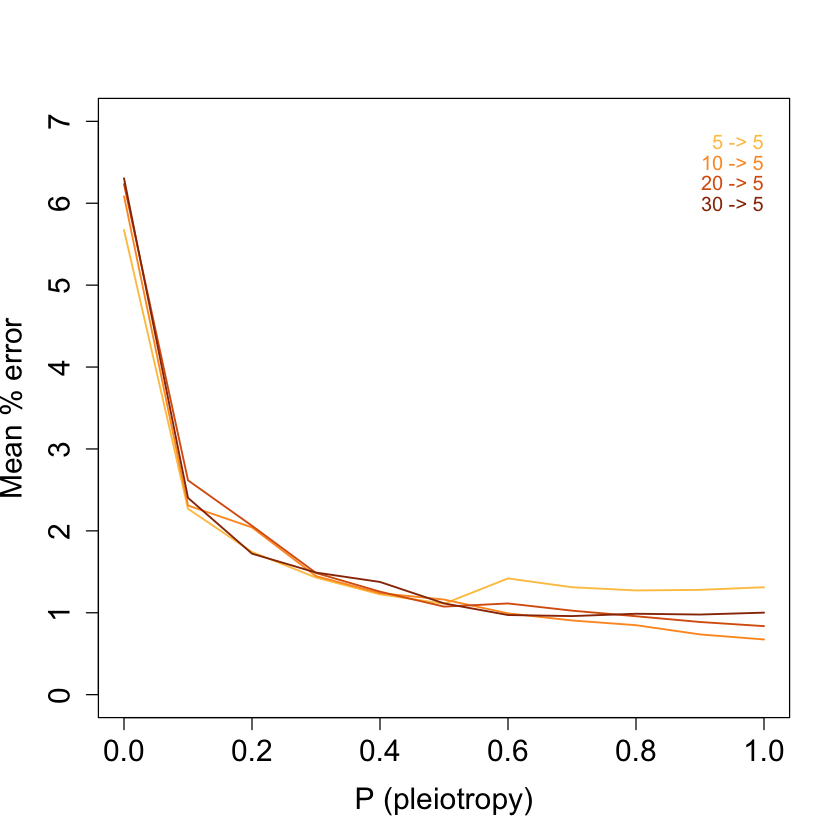

In [32]:
# Get colors
cols <- RColorBrewer::brewer.pal(6, "YlOrBr")[3:6]

# Plot mean
plot(seq(0, 1, 0.1),
  means[[1]],
  type = "l",
  col = cols[1],
  ylim = c(0, 7),
  cex.axis = 1.5,
  cex.lab = 1.5,
  lwd = 1.5,
  ylab = "Mean % error",
  xlab = "P (pleiotropy)"
)
for (i in 2:4) {
  lines(seq(0, 1, 0.1),
    means[[i]],
    col = cols[i],
    lwd = 1.5
  )
}
text(1, 6.75, "5 -> 5", col = cols[1], adj = 1)
text(1, 6.5, "10 -> 5", col = cols[2], adj = 1)
text(1, 6.25, "20 -> 5", col = cols[3], adj = 1)
text(1, 6.0, "30 -> 5", col = cols[4], adj = 1)

## Computing and comparing entropy 

><font size="3"> Finally, we will explore the extent to which phenotypic entropy is associated with predictive accuracy. How does the complexity of information within a set of phenotypes benefit/hinder prediction? Do these patterns vary with phenotype number?

<font size="3"> Split phenotypes on pleiotropy values.

In [33]:
pleio <- unlist(lapply(strsplit(names(phens), "_"), function(v) {
  v[4]
}))

<font size="3"> Calculate entropy statistics across all models.

In [34]:
# Generate vector of phenotype n to test
toTest <- c(5, 10, 20, 30)
# Generate empty list to save results into
ents <- list()
# Loop and calculate
for (i in 1:length(toTest)) {
  # Generate empty list
  tmp <- list()

  # Print progress
  print(paste("n phenotypes =", toTest[i]))

  pb <- txtProgressBar(
    min = 1,
    max = length(phens),
    style = 3,
    width = 50,
    char = "."
  )
  # Loop and calculate for all phenotypes
  for (j in 1:length(phens)) {
    # Update counter
    setTxtProgressBar(pb, j)
    # Randomly sample 600 phenotypes (to reduce comptational load)
    dat <- phens[[j]][sample(nrow(phens[[j]]), 600), 1:toTest[i]]
    # Compute entropy
    #tmp[[j]] <- compute.phenotype.stats(list(dat), run_nonlinear = TRUE)
    tmp[[j]] <- suppressWarnings(compute.phenotype.stats(list(dat)))

  }
  # Add results to list
  ents[[as.character(toTest[i])]] <- tmp
}

[1] "n phenotypes = 5"
  |..................................................| 100%[1] "n phenotypes = 10"
  |..................................................| 100%[1] "n phenotypes = 20"
  |..................................................| 100%[1] "n phenotypes = 30"
  |..................................................| 100%

<font size="3"> Extract mean entropy per pleiotropy value.

In [35]:
# Generate empty list to save results into
stats <- list()
# Loop and calculate
for (i in 1:length(ents)) {
  # Split stats on pleiotropy
  x <- split(ents[[i]], pleio)
  # Generate empty list to save results into
  tmp <- list()
  # Loop and calculate mean statistics for each pleiotropy probability
  for (j in 1:length(x)) {
    # Calculate mean subsampled entropy
    subsampled_entropy_slopes <- mean(unlist(lapply(x[[j]], function(x) unlist(x$subsampled_entropy_slopes))))
    # Calculate mean normalized entropy
    normalized_entropy <- mean(unlist(lapply(x[[j]], function(x) unlist(x$normalized_entropy))))
    # Calculate mean mutual information
    mi <- mean(unlist(lapply(x[[j]], function(x) unlist(x$mutual_information))))
    # Combine into list
    l <- list(
      subsampled_entropy_slopes,
      normalized_entropy,
      mi
    )
    # Add names to list
    names(l) <- c(
      "subsampled_entropy_slopes",
      "normalized_entropy",
      "mutual_information"
    )
    # Add to results list
    tmp[[names(x)[j]]] <- l
  }
  stats[[names(ents)[i]]] <- tmp
}

<font size="3"> Plot entropy slope as a function of pleiotropy.

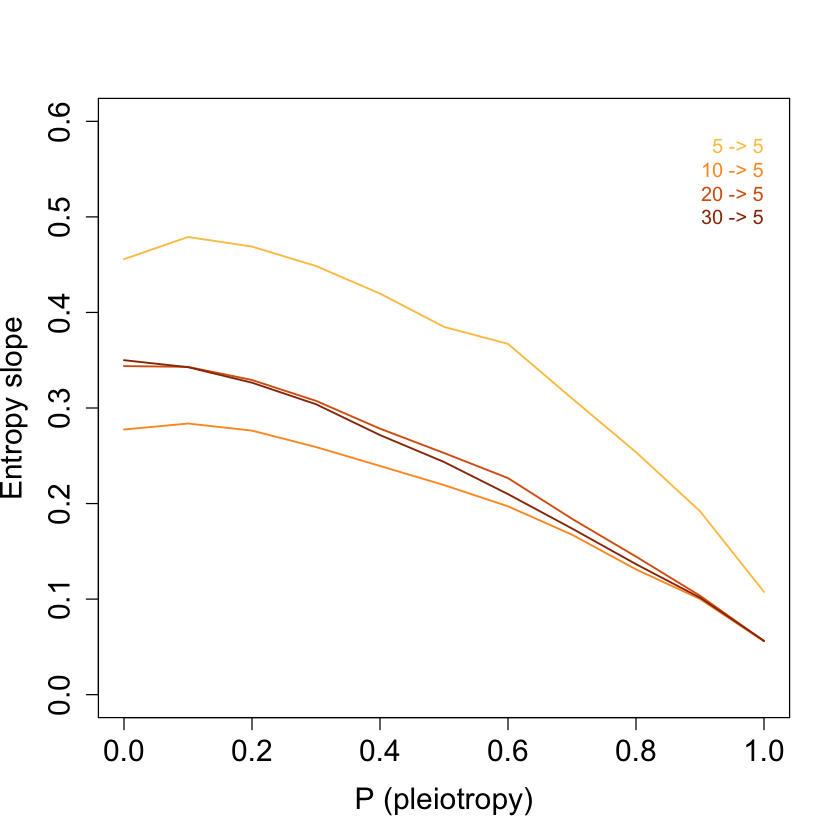

In [36]:
plot(seq(0, 1, 0.1),
  unlist(lapply(stats[[1]], function(x) x$subsampled_entropy_slopes)),
  type = "l",
  col = cols[1],
  ylim = c(0, 0.6),
  cex.axis = 1.5,
  cex.lab = 1.5,
  lwd = 1.5,
  ylab = "Entropy slope",
  xlab = "P (pleiotropy)"
)
for (i in 2:4) {
  lines(seq(0, 1, 0.1),
    unlist(lapply(stats[[i]], function(x) x$subsampled_entropy_slopes)),
    col = cols[i],
    lwd = 1.5
  )
}
text(1, 0.575, "5 -> 5", col = cols[1], adj = 1)
text(1, 0.55, "10 -> 5", col = cols[2], adj = 1)
text(1, 0.525, "20 -> 5", col = cols[3], adj = 1)
text(1, 0.5, "30 -> 5", col = cols[4], adj = 1)

<font size="3"> Compare entropy and error across all models.

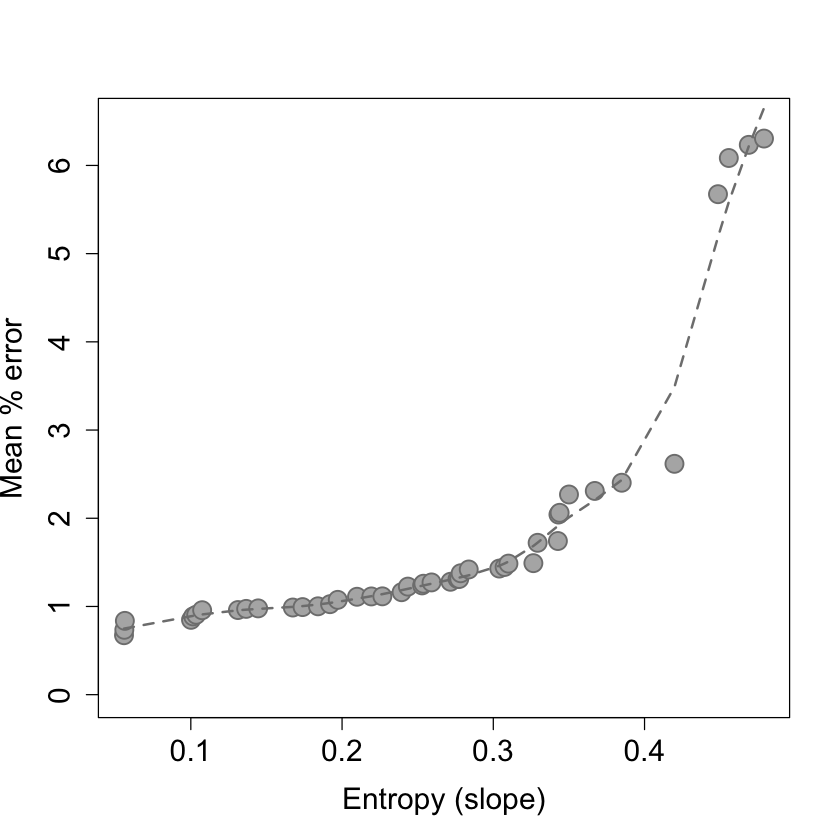

In [37]:
# Plot
plot(sort(unlist(lapply(stats, function(x) lapply(x, function(y) y$subsampled_entropy_slopes)))),
  sort(unlist(means)),
  xlab = "Entropy (slope)",
  pch = 21,
  bg = "gray70",
  col = "gray50",
  cex = 2,
  ylim = c(0, 6.5),
  cex.axis = 1.5,
  cex.lab = 1.5,
  lwd = 1.5,
  ylab = "Mean % error"
)
# Add smoothed spline
s <- smooth.spline(sort(unlist(lapply(stats, function(x) lapply(x, function(y) y$subsampled_entropy_slopes)))),
  sort(unlist(means)),
  spar = 1
)
lines(s$x, s$y, lwd = 2, col = "gray50", lty = "dashed")

<font size="3"> Plot mean error and entropy per phenotype number.

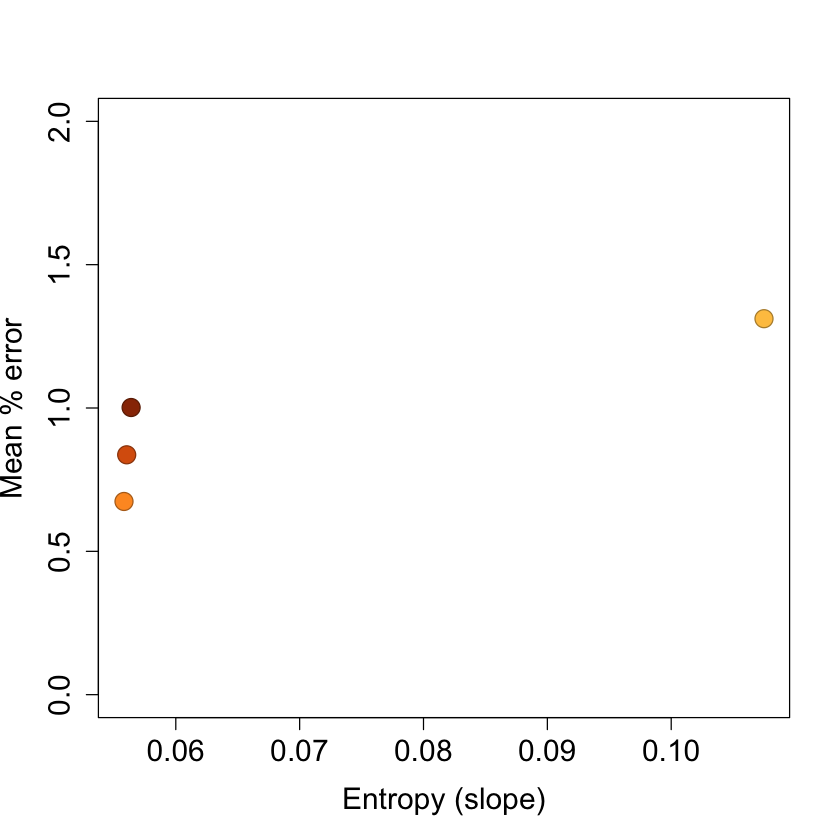

In [38]:
# Plot
plot(unlist(lapply(stats, function(x) lapply(x, function(y) y$subsampled_entropy_slopes)[11])),
  unlist(lapply(means, function(x) x[11])),
  ylim = c(0, 2),
  pch = 21,
  bg = cols,
  col = darken_color(cols),
  cex = 2,
  xlab = "Entropy (slope)",
  ylab = "Mean % error",
  cex.lab = 1.5,
  cex.axis = 1.5
)